# 3장_사이킷런에 있는 머신 러닝 분류 모델

## 3.1 분류 알고리즘 선택

1. 특성을 선택하고 훈련 샘플 모으기
2. 성능 지표 선택
3. 분류 모델과 최적화 알고리즘 선택
4. 모델의 성능 평가
5. 알고리즘 튜닝

## 3.2 사이킷런 첫걸음: 퍼셉트론 훈련

사이킷런에서 붓꽃 데이터셋을 적재합니다. 세 번째 열은 꽃잎의 길이이고 네 번째 열은 꽃잎의 너비입니다. 클래스는 이미 정수 레이블로 변환되어 있습니다. 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica 입니다.

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split

# train_data 70% / test_data 30%로 나눠준다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


StandardScaler의 fit 메서드는 훈련 데이터셋의 각 특성마다 $\mu$(샘플 평균)와 $\delta$(표준 편차)를 계산하여 transform 메서드로 훈련 데이터셋을 표준화

In [3]:
from sklearn.preprocessing import StandardScaler

# 특성 표준화
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

사이킷런의 알고리즘은 대부분 기본적으로 <strong>OvR</strong>(One-versus_Rest) 방식을 사용하여 다중 분류 지원  
세 개의 붓꽃 클래스를 퍼셉트론 모델에 적용

In [4]:
from sklearn.linear_model import Perceptron

# Perceptron 모델 학습
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

# 모델 예측
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

# 정확도
from sklearn.metrics import accuracy_score
print(f'정확도: {accuracy_score(y_test, y_pred):.3f}')

잘못 분류된 샘플 개수: 1
정확도: 0.978


### 모델 시각화

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
    
    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

모델이 찾은 결정 경계와 산점도

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


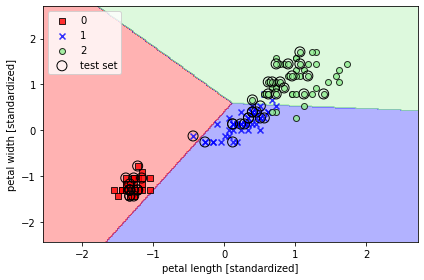

In [6]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_01.png', dpi=300)
plt.show()

### 퍼셉트론 마무리

간단하고 좋은 모델이지만, 클래스가 선형적으로 구분되어 있지 않을 때 수렴하지 않아 실전에서는 잘 사용하지 않는다.  
에포크마다 적어도 하나의 샘플이 잘못 분류되기 때문에 가중치 없데이트가 끝나지 않는다.

## 3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

간단하지만 선형 이진 분류 문제데 퍼셉트론보다 더 강력한 알고리즘 -> 로지스틱 회귀<strong>(분류 모델)</strong>

### 3.3.1 로지스틱 회귀의 이해 / 조건부 확률

오즈비(특정 이벤트가 발생할 확률) $=\dfrac{P}{1-P}$ , ($P$는 양성 샘플에 대한 확률)

로짓 함수 : $logit(P)=log\dfrac{P}{1-P}$

$0\le P \le 1$이면, $0 \le \dfrac{P}{1-P} \le \infty$이고, $-\infty \le log\dfrac{P}{1-P} \le \infty$이므로

$log\dfrac{P}{1-P}=\boldsymbol{w}^T\boldsymbol{x}$처럼 쓸 수 있다.

따라서 양성 샘플일 확률 $P = \dfrac{1}{1+e^{-\boldsymbol{w}^T\boldsymbol{x}}}=\dfrac{1}{1+e^{-z}}$

이 함수를 시그모이드 함수(sigmoid function)라고 한다.  
$\phi(z) = \dfrac{1}{1+e^{-z}}$

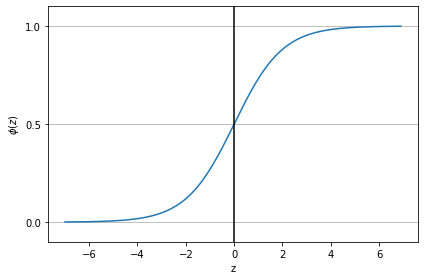

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('images/03_02.png', dpi=300)
plt.show()

로지스틱 회귀 모델에서의 활성화 함수 -> 시그모이드 함수

### 아달린과 로지스틱 회귀의 차이점

로지스틱 회귀는 입력 벡터가 특정 클래스에 속할 확률을 출력해준다.

In [8]:
from IPython.display import Image
Image(url='https://git.io/Jtm22', width=500) 

### 3.3.2 로지스틱 비용 함수의 가중치 학습

가능도 : $L(\boldsymbol w)=\prod^n_{i=1}\phi(z^{(i)})^{y^{(i)}}\left(1-\phi(z^{(i)})\right)^{1-y^{(i)}}$

로그 가능도 : $\text{log} L(\boldsymbol w)=\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]$

로지스틱 비용 함수 : $J(\boldsymbol w)=-\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]$

손실 계산 : $J(\boldsymbol w)=\begin{cases}-\text{log}\phi(z)&y=1\mbox{ 일 때} \\ -\text{log}(1-\phi(z))&y=0\mbox{일 때}\end{cases}$

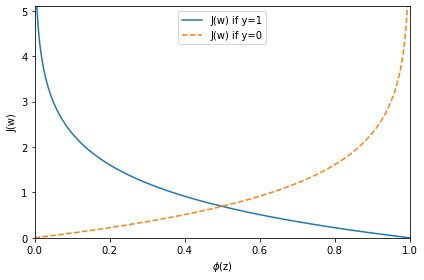

In [9]:
# 샘플이 하나일 때 값에 대한 분류 비용

def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/03_04.png', dpi=300)
plt.show()

### 3.3.3 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

로지스틱 손실 함수의 미분 :

$\begin{align*}
\dfrac{\partial}{\partial w_j}J(\boldsymbol w)&=-\dfrac{\partial}{\partial w_j}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right] \\
&=-y^{(i)}\dfrac{\partial}{\partial w_j}\text{log}\phi(z^{(i)})-(1-y^{(i)})\dfrac{\partial}{\partial w_j}\text{log}\left(1-\phi(z^{(i)})\right) \\
&=-y^{(i)}\dfrac{1}{\phi(z^{(i)})}\dfrac{\partial}{\partial w_j}\phi(z^{(i)})+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\dfrac{\partial}{\partial w_j}\phi(z^{(i)}) \\
&=\left(-y^{(i)}\dfrac{1}{\phi(z^{(i)})}+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\right)\dfrac{\partial}{\partial w_j}\phi(z^{(i)}) \\
\end{align*}$

시그모이드 함수를 z에 대해 미분하면 : 

$\dfrac{\partial}{\partial z}\phi(z)=\dfrac{\partial}{\partial z}\left(\dfrac{1}{1+e^{-z}}\right)=-\dfrac{1}{(1+e^{-z})^2}(-e^{-z})=\dfrac{1+e^{-z}-1}{(1+e^{-z})^2}=\dfrac{1+e^{-z}}{(1+e^{-z})^2}-\dfrac{1}{(1+e^{-z})^2}=\dfrac{1}{1+e^{-z}}\left(1-\dfrac{1}{1+e^{-z}}\right)=\phi(z)(1-\phi(z))$

따라서, 

$\begin{align*}
\dfrac{\partial}{\partial w_j}J(\boldsymbol w)&=\left(-y^{(i)}\dfrac{1}{\phi(z^{(i)})}+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\right)\phi(z^{(i)})\left(1-\phi(z^{(i)})\right)\dfrac{\partial}{\partial w_j}z^{(i)} \\
&=\left(-y^{(i)}\left(1-\phi(z^{(i)})\right)+(1-y^{(i)})\phi(z^{(i)})\right)x_j^{(i)}\\
&=\left(-y^{(i)}+y^{(i)}\phi(z^{(i)})+\phi(z^{(i)})-y^{(i)}\phi(z^{(i)})\right)x_j^{(i)}\\
&=-\left(y^{(i)}-\phi(z^{(i)})\right)x_j^{(i)}
\end{align*}$

In [10]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        # 대신 from scipy.special import expit; expit(z) 을 사용할 수 있습니다.
        # np.clip(array, min, max) -> min보다 작은 값을 min으로 / max보다 큰 값을 max로 바꿔줌
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Iris_setosa (y_train == 0)  
Iris-versicolor (y_train == 1)  
2 종류의 붓꽃만 가지고 로지스틱 회귀 구현 확인

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


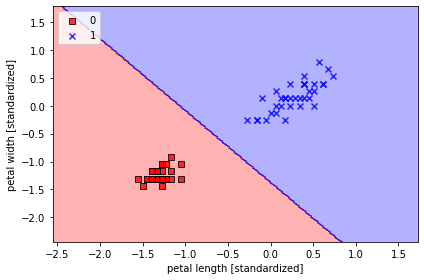

In [11]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_05.png', dpi=300)
plt.show()

### 3.3.4 사이킷런 사용한 로지스틱 회귀 모델

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


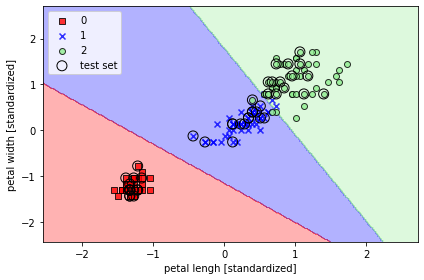

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std,
    y_combined,
    classifier=lr,
    test_idx=range(105,150)
)
plt.xlabel('petal lengh [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- [ ] 매개변수 C 설명 필요

In [13]:
lr.predict_proba(X_test_std[:3,:])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

In [14]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [15]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [16]:
lr.predict(X_test_std[:3,:])

array([2, 0, 0])

In [17]:
lr.predict(X_test_std[0,:].reshape(1, -1))

array([2])

In [18]:
# logistic regression 정확도
y_pred_lr = lr.predict(X_test_std)
print("prediction accuracy: {:.2f}".format(np.mean(y_pred_lr == y_test)))

prediction accuracy: 0.98


### 3.3.5 규제를 사용하여 과적합 피하기

<strong>과대적합</strong>(overfitting): 훈련데이터는 잘 동작하지만 테스트데이터의 결과가 좋지 않은 경우  
<strong>과소적합</strong>(underfitting): 모델이 너무 간단한 경우 -> 패턴을 찾지 못해 훈련데이터 / 테스트데이터 모두 결과가 좋지 않음

In [19]:
Image(url='https://git.io/Jtm2V', width=700) 

<strong>규제</strong>는 공선성(특성 간 높은 상관관계)를 다루거나 데이터에서 잡음 제거하여 과적합을 방지하는 방법  
규제가 잘 작동하려면 모든 특성이 비슷한 스케일을 가져야 함 -> 표준화 하는 이유

L2 규제(L2 노름의 제곱) : $\lVert\boldsymbol{w}\rVert^2=\sum_{j=1}^m w_j^2$

L1 규제(L1 노름) : $\lVert\boldsymbol{w}\rVert_1=\sum_{j=1}^m \left|w_j\right|$

규제가 추가된 비용 함수 : $J(\boldsymbol w)=-\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]+\dfrac{\lambda}{2}\sum_{j=1}^m w_j^2$

- `C`는 $\lambda$의 역수로 증가시키면 규제가 작아지고, 감소시키면 규제가 커짐. 기본값은 1.0
- `penalty` 매개변수 기본값 `'l2'`, L1 규제를 위해 `'l1'`을 지정할 수 있음.

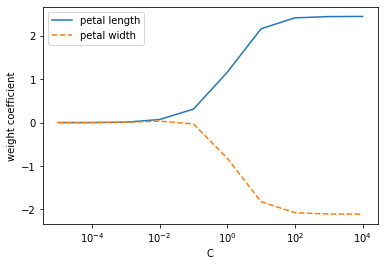

In [20]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('images/03_08.png', dpi=300)
plt.show()

매개변수 C가 감소하면 가중치 절댒값이 줄어든다 -> 규제 강도 증가

## 3.4 서포트 벡터 머신을 사용한 최대 마진 분류

<strong>서포트 벡터 머신</strong>(Support Vector Machine, SVM)은 퍼셉트론의 확장  
```
퍼셉트론: 분류 오차 최소화
SVM: 마진 최대화
```

In [21]:
Image(url='https://git.io/Jtm2r', width=700)

### 3.4.1 최대 마진

양성 쪽 초평면 : $w_0+\boldsymbol{w}^T\boldsymbol{x}_{pos}=1$

음성 쪽 초평면 : $w_0+\boldsymbol{w}^T\boldsymbol{x}_{neg}=-1$

두 식을 빼고 : $\boldsymbol{w}^T(\boldsymbol{x}_{pos}-\boldsymbol{x}_{neg})=2$

가중치의 L2 노름으로 나눈다 : $\dfrac{\boldsymbol{w}^T(\boldsymbol{x}_{pos}-\boldsymbol{x}_{neg})}{\lVert \boldsymbol w \rVert}=\dfrac{2}{\lVert \boldsymbol w \rVert}$

결국 SVM은 $\dfrac{2}{\lVert \boldsymbol w \rVert}$을 최대화하는 문제이다. 실제로는 $\dfrac{1}{2}\lVert \boldsymbol w \rVert^2=\dfrac{1}{2}\boldsymbol w^T \boldsymbol w$를 최소화한다.

### 3.4.2 슬랙 변수를 사용하여 비선형 분류 문제 다루기

<strong>소프트 마진 분류</strong>(soft margin classification  
선형으로 구분 되지 않을 때는 비용을 적절히 손해 보면서 오차를 최소화하는 방식

양성 샘플일 때 : $w_0+\boldsymbol w^T \boldsymbol x^{(i)} \ge 1-\zeta^{(i)}$

음성 샘플일 때 : $w_0+\boldsymbol w^T \boldsymbol x^{(i)} \le -1+\zeta^{(i)}$

목적 함수 : $\dfrac{1}{2} \boldsymbol w^T \boldsymbol w+C\sum_i \zeta^{(i)}$

매개변수 C값을 사용하여 마진 폭을 제어 -> C값이 커지면 분류 오차 엄격 / C값이 작아지면 분류 오차 덜 엄격

In [22]:
Image(url='https://git.io/Jtm26', width=600) 

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


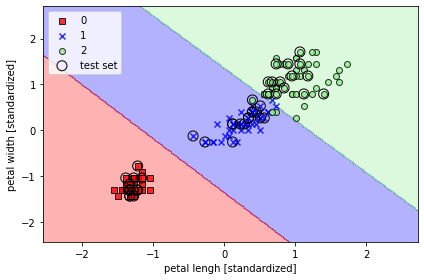

In [23]:
# 붓꽃 데이터셋의 꽃 분류 분제 SVM으로 훈련

from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std,
    y_combined,
    classifier=svm,
    test_idx=range(105,150)
)
plt.xlabel('petal lengh [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# svm 정확도
y_pred_svm = svm.predict(X_test_std)
print("prediction accuracy: {:.2f}".format(np.mean(y_pred_svm == y_test)))

prediction accuracy: 0.98


#### 로지스틱 회귀(lr) vs 서포트 벡터 머신(svm)

실제 분류 작업에서 둘은 매우 비슷한 결과를 나타내지만, svm보다 lr이 이상치에 민감  
svm은 결정 경계에 가장 가까운 포인트(서포트 벡터)에 영향을 받음  
lr은 모델이 간단하고 구현이 더 쉬워 업데이트가 용이하므로 스트리밍 데이터를 다룰 때 적합

### 3.4.3 사이킷런의 다른 구현

가끔씩 데이터셋이 너무 커서 컴퓨터 메모리 용량에 맞지 않는 경우  
사이킷런은 이에 대한 대안으로 SGDClassifier 클래스를 제공  
```python
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')
```

## 3.5 커널 SVM을 사용한 비선형 문제 풀기

### 3.5.1 선형적으로 구분되지 않는 데이터를 위한 커널 방법

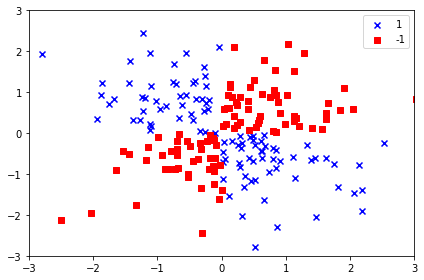

In [25]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
# 1개만 참일 때 True / 나머지는 False 반환
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/03_12.png', dpi=300)
plt.show()

이 모양에는 선형 초평면으로 구간을 나눌 수 없어 보인다.

선형적으로 구분되지 않는 데이터를 다루는 <strong>커널 방법</strong>(kernel method)의 기본 아이디어  
-> 매핑 함수 $\mu$를 사용하여 원본 특성의 비선형 조합을 선형적으로 구분되는 고차원 공간에 투영

$\phi(x_1, x_2)=(x_1, x_2, x_1^2+x_2^2)$

In [26]:
Image(url='https://git.io/Jtm2X', width=700) 

### 3.5.2 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기

<strong>커널</strong>(kernel)을 <strong>유사도 함수</strong>(similarity function)로 해석할 수 있다.

널리 사용되는 커널 함수  
- 방사 기저 함수(Radial Basis Function)

$K(\boldsymbol x^{(i)}, \boldsymbol x^{(j)})=\text{exp}\left(-\dfrac{1}{2\sigma^2}\lVert \boldsymbol x^{(i)}-\boldsymbol x^{(j)} \rVert^2\right)=\text{exp}\left( -\gamma\lVert \boldsymbol x^{(i)}-\boldsymbol x^{(j)} \rVert^2 \right)$

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


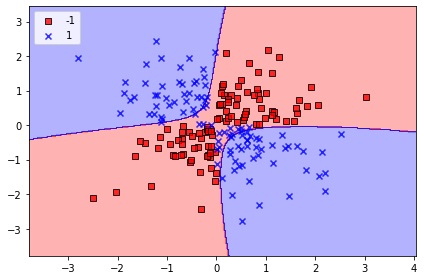

In [27]:
svm_rbf = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm_rbf.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_rbf)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_14.png', dpi=300)
plt.show()

### 매개변수 $\gamma$ 영향 확인

$\gamma$ 작을 때 / 서포트 벡터의 영향이나 범위가 늘어남

$\gamma$ 클 때 / 서포트 벡터의 영향이나 범위가 줄어든다

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


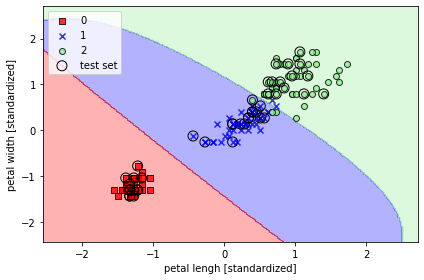

In [28]:
# 매개변수 gamma 작게 조절

svm_rbf2 = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm_rbf2.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std,
    y_combined,
    classifier=svm_rbf2,
    test_idx=range(105,150)
)
plt.xlabel('petal lengh [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


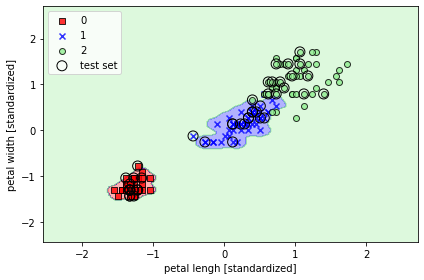

In [29]:
# 매개변수 gamma 크게조절

svm_rbf3 = SVC(kernel='rbf', random_state=1, gamma=100, C=1.0)
svm_rbf3.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std,
    y_combined,
    classifier=svm_rbf3,
    test_idx=range(105,150)
)
plt.xlabel('petal lengh [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

훈련데이터는 잘 맞지만 테스트를 했을 때에는 오차가 높을 것이다

## 결정 트리 학습

In [30]:
Image(url='https://git.io/Jtm21', width=500) 

### 3.6.1 정보 이득 최대화: 자원을 최대로 활용

I: 불순도  
N_p: 부모 노드에 있는 전체 샘플 개수  
정보 이득 -> 부모 노드의 불순도 - 자식 노드의 불순도

$IG = I_p - \dfrac{N_{left}}{N_p}I_{left} - \dfrac{N_{right}}{N_p}I_{right}$

In [31]:
Image(url='https://git.io/Jtm2D', width=500) 

- [ ] P.123 ~ P.125 질문!!!!

P.124에서 '$B: I_E(D_{right})$' 부분 계산이 이해가 안가요ㅜ

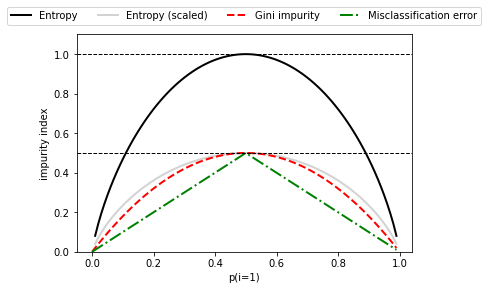

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
# plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.6.2 결정 트리 만들기

결정 트리는 특성 공간을 사각 격자로 나누기 때문에 복잡한 결정 경계를 만들 수 있음  
but 트리가 깊어질수록 과대적합의 위험성이 있음

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


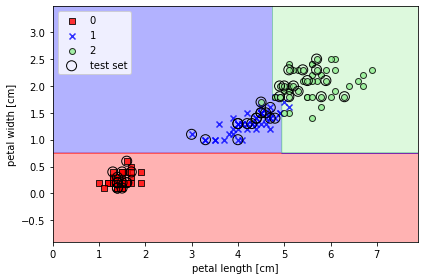

In [33]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_20.png', dpi=300)
plt.show()

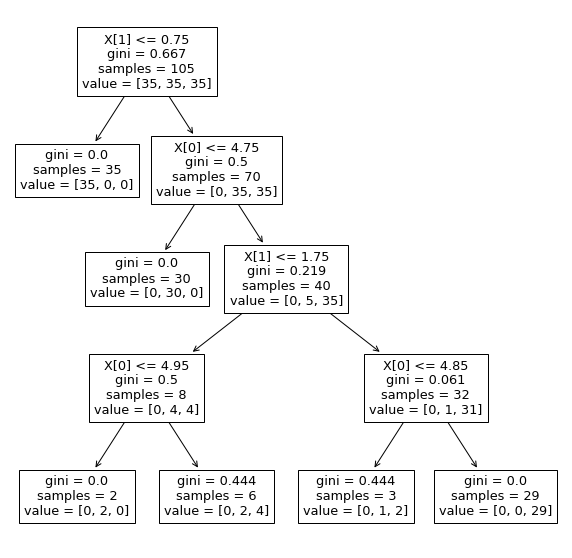

In [34]:
# plot_tree()함수로 그린 결정 트리(사이킷런에서 훈련 끝난 결정 트리 시각화 기능)

from sklearn import tree
plt.figure(figsize=(10,10))
tree.plot_tree(tree_model)
plt.show()

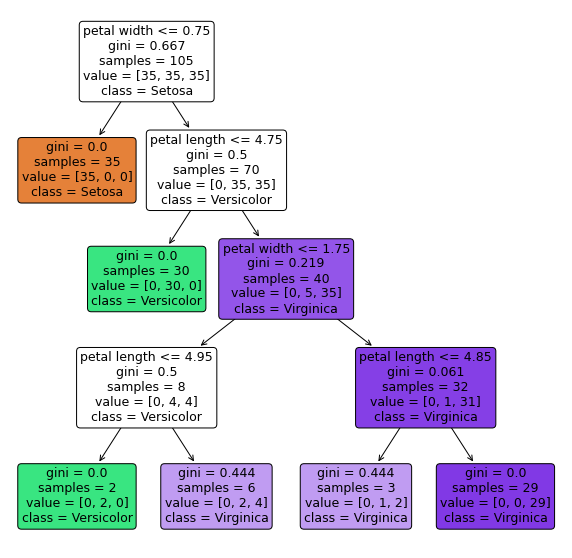

In [35]:
plt.figure(figsize=(10,10))
tree.plot_tree(tree_model,
               impurity=True,
               filled=True, 
               rounded=True,
               class_names=['Setosa', 
                            'Versicolor',
                            'Virginica'],
               feature_names=['petal length', 
                              'petal width'])
plt.show()

In [36]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

결정 트리에서 지원하는 대표적인 사전 가지 치기

- max_leaf_nodes: 리프 노드 최대 개수 (default None)
- min_samples_leaf: 리프 노드가 되기 위한 최소 샘플 개수 or 샘플 비율 (default 1)
- min_samples_split: 노드 분할을 위한 최소 샘플 개수 or 샘플 비율 (default 2)
- min_impurity_decrease: 노드 분할이 감소시킬 최소 불순도 (default 0)

### 3.6.3 랜덤 포레스트로 여러 개의 결정 트리 연결

앙상블 기법: 이미 훈련한 모델을 개선하여 더 뛰어난 분류 성능과 과대적합에 안정적으로 만들어준다. (배깅, 부스팅, 등등)

<strong>랜덤 포레스트</strong>(random forest): 결정 트리의 <strong>앙상블</strong>(ensemble)  
아이디어 -> 여러 개의 결정 트리 평균  
각각의 트리는 분산이 높은 문제가 있지만 앙상블은 견고한 모델을 만들어 일반화 성능을 높이고 과대적합을 줄여준다.

랜덤 포레스트는 해석이 쉽지 않지만 하이퍼파라미터 튜닝에 많은 노력을 기울이지 않아도 된다.  
트리 개수 parameter: 트리 개수가 많을수록 계산 비용이 증가하여 분류기의 성능 증가  
부트스트랩 샘플 크기 parameter: 크기가 작아지면 개별 트리의 다양성이 증가해 랜덤 포레스트의 무작위성이 증가하고 과대적합의 영향 줄어듦

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


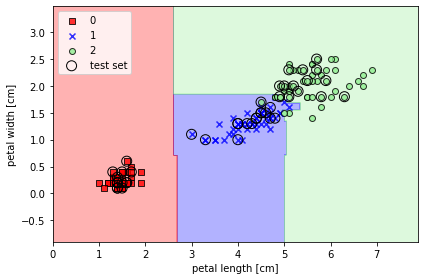

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_22.png', dpi=300)
plt.show()

## 3.7 K-최근접 이웃

KNN 알고리즘(비모수 모델)

1. 숫자 k와 거리 측정 기준을 선택
2. 분류하려는 샘플에서 k개의 최근접 이웃 찾기
3. 다수결 투표를 통해 클래스 레이블 할당

In [38]:
Image(url='https://git.io/Jtm25', width=400) 

C:\Users\user\AppData\Local\Temp/ipykernel_1516/1953989963.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


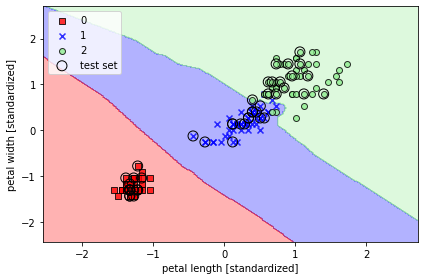

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# 매개변수 p=1 -> 맨해튼 거리 / p=2 -> 유클리디안 거리
knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_24.png', dpi=300)
plt.show()